# Название проекта:

# Cервис аренды самокатов

**Цель проекта:**
**Проверка гипотез о взаимосвязи между наличием или отсутствием подписки на сервис и группой заданных факторов.** 

Описание проекта.

Шаг 1. Загрузка данных

Получены данные о пользователях, поездках и типах подписки.

Шаг 2. Предобработка данных

Рассмотрена общая информация о каждом из трех наброов данных. 
Проверено наличие пропусков и дубликатов. В файле о пользователях удален 31 полный дубликат. Пропусков не обнаружено.

В данных о поездках колонка date приведедна к типу данных datetime.
В данных о пользователях и типах подписки колонка subscription_type приведена к типу category.
В даннх о поездках добалена колонка с нмоером месяца, на основе date.

Шаг 3. Исследовательский анализ данных

Выполнен краткий анализ данных с визуализайией информации:
* 3.1 частота встречаемости городов;
* 3.2 соотношение пользователей с подпиской и без подписки;
* 3.3 возраст пользователей;
* 3.4 расстояние, которое пользователь преодолел за одну поездку;
* 3.5 продолжительность поездок.

Построены диаграммы размаха и определены нормлаьные границы данных по определенным параметрам.
Выборка скорректирована путем удаления аномальных значений и выбросов.

Шаг 4. Объединение данных

Данные о пользователях, поездках и подписках в один датафрейм методом .merge().
На базе полученного файла созданы два датафрейма по параметру наличие или отсутствие подписки:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

Шаг 5. Подсчёт выручки

На основе объединенного датафрейма созан файл с агрегированными данными о поездках: определено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
Добавлен столбец с помесячной выручкой, которую принёс каждый пользователь. Продолжительность каждой поездки для подсчёта стоимости округляется до следующего целого числа.

Шаг 6. Проверка гипотез

Проверены гипотезы:
* 6.1 Тратят ли пользователи с подпиской больше времени на поездки.
* 6.2 Не превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, 3130 метров.
* 6.3 Приносят ли по месяцам пользователи с подпиской выручку большую, чем пользователи без подписки. 
* 6.4 Определено, какой тест понадобитс для проверки гипотезы при условии измерения выборки До и После некоторых изменений.


Шаг 7. Распределения (тут сделана некоторая попытка выполнить задание, но времени катострофически не хватает, а не понятно, почему не работает, поэтому, пожалуйста, напишите комментарии, и во 2м подходе, постараюсь сделать более удобоваримую версию).

Сделаем несколько предварительных шагов.

In [79]:
# Импортируем в одном поле все, что нужно

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

from math import sqrt
from math import factorial
from scipy import stats as st
from scipy.stats import binom, norm

In [80]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [81]:
# Отображение 2-х десятичных знаков

pd.options.display.float_format = '{:.2f}'.format

#### Шаг 1. Загрузка данных

Загрузим поочередно 3 базы данных: пользователей (users), поездки (rides) и подписки (subscriptions).
Выведем для каждой базы первые 5 строк, чтобы посмотреть, корректно ли прочитан файл.

In [82]:
# База данных о пользователях

users = pd.read_csv(# путь к файлу)
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [83]:
# База данных о поездках

rides = pd.read_csv(# путь к файлу)
rides.head()

,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


In [84]:
# База данных о типах подписки

subscriptions = pd.read_csv(# путь к файлу)
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 2. Предобработка данных

Создадим функцию, которая удалит все явные дубликаты, выведет общую информацию и число пропусков в базе.

In [85]:
def data_info(name):
    
    d_count = f'Число явных дубликатов до удаления: {name.duplicated().sum()}'
    name = name.drop_duplicates()
    
    info = name.info()
    na = name.isna().sum()
    
    return info, na, d_count

Рассмотрим последовательно наши базы данных.

In [86]:
# Информация и число пропусков в базе users

data_info(users)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


(None,
 user_id              0
 name                 0
 age                  0
 city                 0
 subscription_type    0
 dtype: int64,
 'Число явных дубликатов до удаления: 31')

Удалены 31 явный дубликат. Пропусков нет. В колонке subscription_type поменяем формат с object на category (это будет занимать меньше памяти).

In [87]:
users['subscription_type'] = users['subscription_type'].astype('category')

In [88]:
# Информация и число пропусков в базе rides

data_info(rides)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 705.8+ KB


(None,
 user_id     0
 distance    0
 duration    0
 date        0
 dtype: int64,
 'Число явных дубликатов до удаления: 0')

Дубликатов и пропусков не было. В колонке date поменяем тип данных с object на datetime.

In [89]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Добавим новый столбец с номером месяца.

In [90]:
rides['month_num'] = rides['date'].dt.month

In [91]:
# Проверим какой период охватывают данные, если несколько лет, добавим год.

rides['date'].min(), rides['date'].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

In [92]:
# Информация и число пропусков в базе subscriptions

data_info(subscriptions)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes


(None,
 subscription_type    0
 minute_price         0
 start_ride_price     0
 subscription_fee     0
 dtype: int64,
 'Число явных дубликатов до удаления: 0')

Дубликатов и пропусков не было. В колонке subscription_type поменяем формат с object на category.

In [93]:
subscriptions['subscription_type'] = subscriptions['subscription_type'].astype('category')

#### Шаг 3. Исследовательский анализ данных

Рассмотрим частоту встречаемости городов в данных о пользователях.

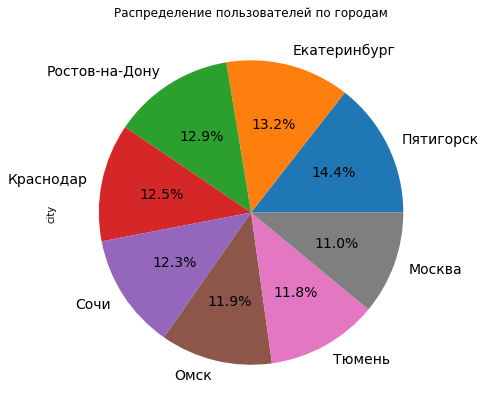

In [94]:
users['city'].value_counts(
).to_frame(
).plot(
    title="Распределение пользователей по городам",
    kind = 'pie',
    y='city',
    figsize = (7,7),
    rot = 0,
    legend = False,
    fontsize = 14,
    autopct='%1.1f%%'
);

В целом, довольно схожие показатели по городам.

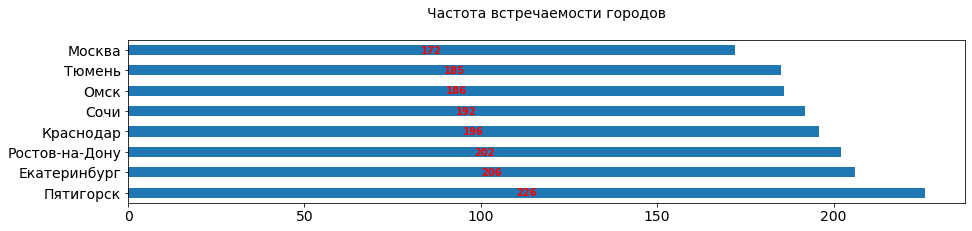

In [95]:
# Посмотрим на графике другого типа, так лучше видна разница городов

ax = users['city'].value_counts(
).to_frame(
).plot(
    kind = 'barh',
    figsize = (15,3),
    rot = 0,
    legend = False,
    fontsize = 14,
    tick_label = 'city_count'   
)

plt.title('Частота встречаемости городов' + "\n", fontsize=14, color='Black');

for p in ax.patches:
    ax.annotate(
        str(p.get_width()),
        (p.get_x() + p.get_width() * 0.5, p.get_y() + p.get_height() * 0.5),
        ha='center', va='center', color='red', fontweight='bold'
    );


Чаще всего встречается Пятигорск, реже всего Москва.

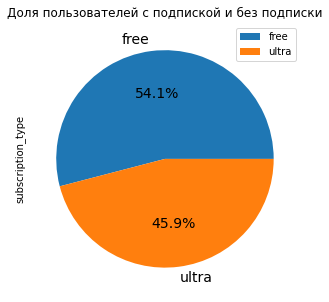

In [96]:
# Визуализируем число пользователей с подпиской и без

users['subscription_type'].value_counts(
).to_frame(
).plot(
    title="Доля пользователей с подпиской и без подписки",
    y='subscription_type',
    kind = 'pie',
    fontsize = 14,
    autopct='%1.1f%%',
    figsize=(5,5)
);

Пользователей без подписки немногим больше, чем с подпиской.

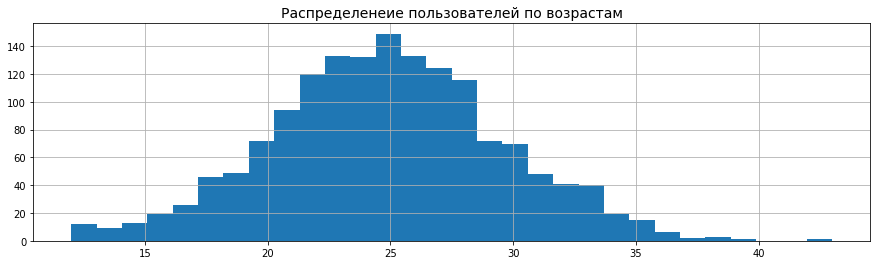

In [97]:
# Распределение пользователей по возрастам

users['age'].hist(bins=30, figsize=(15,4)).set_title(label="Распределенеие пользователей по возрастам", size=14);


In [98]:
# UPD

# Определим основные числовые характеристики таблицы с пользователями

users['age'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,1565.00,24.92,4.55,12.00,22.00,25.00,28.00,43.00


UPD:
Минимальный возраст пользователей 12 лет, максимальный - 43 года. Медианное значение составляет 25 лет (среднее близко к этому = 24,92). 25 % пользователей до 22 лет, 75% пользователей до 28. Можно отметить, что основная группа пользователей от 20 до 30 лет.

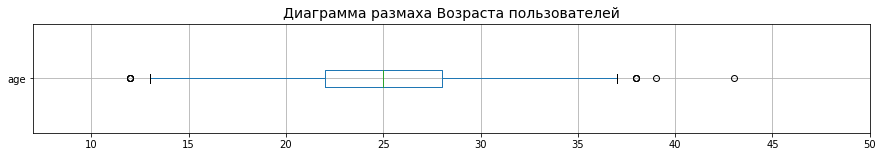

In [99]:
# Построим диаграмму размаха для возраста пользователей

fig, ax = plt.subplots(figsize = (15,2))
ax = users[['age']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Возраста пользователей', size = 14)
ax.set_xlim(7,50);

С точки зрения распределения возрастов, нормальные значения от 14 до 36 лет. Остальные данные (но не пользователи )) ) выглядят, как выбросы.

In [100]:
# Узнаем долю этих записей в общем объеме базы пользователей

(users.query('age >= 37 or age < 13')['age'].count() / users.shape[0])*100

0.7028753993610224

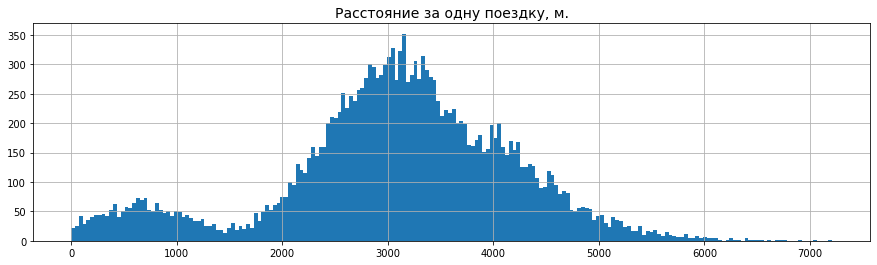

In [101]:
# Посмотрим на расстояние

rides['distance'].hist(bins=200, figsize=(15,4)).set_title(label="Расстояние за одну поездку, м.", size=14);

Тут получается 2 группы поездок - на короткие и длинные дистанции. Слишком короткие поездки (до 1-2 минут), может и стоит отбросить, но в целом этот пик на 800 м. может быть отдельной категорией поездок.

''

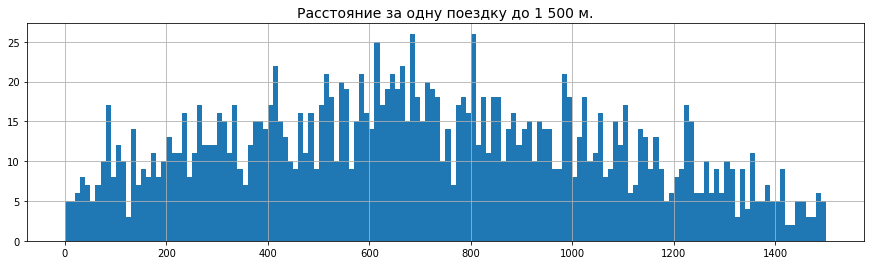

In [102]:
# Посмотрим как распределяются короткие поездки

rides['distance'].hist(bins=150, figsize=(15,4), range=(0, 1500)).set_title(label="Расстояние за одну поездку до 1 500 м.", size=14);
;

In [103]:
# Их количество:

rides.query('distance <= 1500')['distance'].count()

1796

In [104]:
# И процент от общего числа записей в базе поездок:

(rides.query('distance <= 1500')['distance'].count() / rides.shape[0])*100

9.940225813593093

UPD: Процент довольно большой. 
Возможно, действительно, неправильно указаны единицы измерения - вместо км - метры, например.
Стоит отметить это в БАГ-репорте.

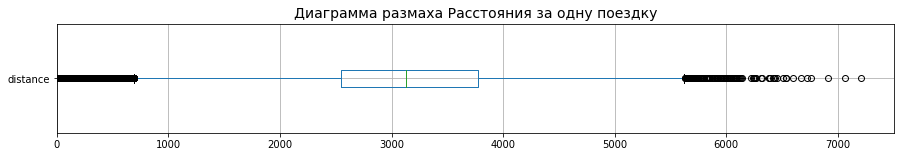

In [105]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (15,2))
ax = rides[['distance']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Расстояния за одну поездку', size = 14)
ax.set_xlim(0,7500);

Согласно диаграмме размаха, нормальные значения расположены от 750 до 5700 м.

In [106]:
# UPD

# Определим основные числовые характеристики таблицы с поездками

rides[['distance', 'duration']].describe()

,distance,duration
count,18068.00,18068.00
mean,3070.66,17.81
std,1116.83,6.09
min,0.86,0.50
25%,2543.23,13.60
50%,3133.61,17.68
75%,3776.22,21.72
max,7211.01,40.82


Минимальное занчение дистанции составляет 0,86 м. и продолжительность поездки 0,5 мин. Если, допустим, тут ошибка в единицах измерения, то это будет вполне приемлемое значение 860 метров. Также - информация для БАГ-репорта.
(спасибо за подсказку!)

Медианные значения составляют 3 133 метра и 17,68 минут. 25% пользователей совершают поездки до 2 543 метров за 13,6 минут. 75% пользователей преодолевают 3 776 метров до 21,7 минут.

Можно отметить, что основная часть пользователей проезжает расстояние от 2,5 до 3,8 км, продолжительностью от 13 до 22 минут.

#Оставим в выборке значение без выбросов

#rides = rides.query('distance >= 750 and distance <= 5700')

#rides['distance'].hist(bins=200, figsize=(15,4)).set_title(label="Расстояние за одну поездку, м.", size=14);

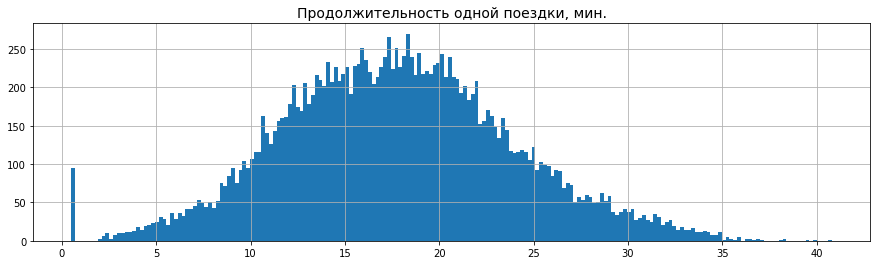

In [107]:
# Посмотрим на распределение продолжительности поездок.

rides['duration'].hist(bins=200, figsize=(15,4)).set_title(label="Продолжительность одной поездки, мин.", size=14);

In [108]:
# Поездки до 2 минут:

rides.query('duration <= 2')['duration'].count()

95

Тут явная ошибка данных, с продолжительностью поездки в 1 минуту. Или сбой приложения, например.

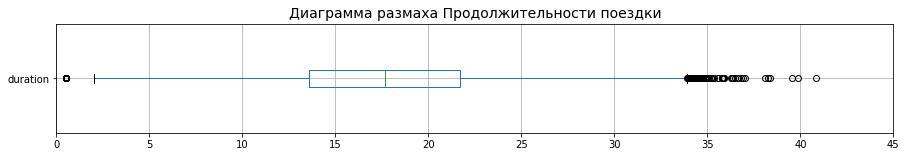

In [109]:
# Построим диаграмму размаха

fig, ax = plt.subplots(figsize = (15,2))
ax = rides[['duration']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха Продолжительности поездки', size = 14)
ax.set_xlim(0,45);

Здесь нормальные значения от 4 до 34 минут. 
В принципе, при скорости самоката 30 км/ч за 3 минуты можно проехать 1,5 км.

In [110]:
# Доля поездок с нетипичной продолжительностью от общего объема базы поездок:

(rides.query('duration <= 3 or duration >= 34')['duration'].count() / rides.shape[0])*100

1.1235333185742749

#### Шаг 4. Объединение данных

Объединим все три таблицы в одну методом .merge() по колонке user_id и subscription_type.

UPD:
Воспользуемся параметром outer, чтобы получить максимально полные данные.

In [111]:
data = users.merge(rides, on='user_id', how='outer').merge(subscriptions, on='subscription_type', how='outer')

In [112]:
# UPD

# Выведем первые 5 строк таблицы

data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199


In [113]:
# UPD 

# Выведем информацию о файле

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   name               18388 non-null  object        
 2   age                18388 non-null  int64         
 3   city               18388 non-null  object        
 4   subscription_type  18388 non-null  category      
 5   distance           18388 non-null  float64       
 6   duration           18388 non-null  float64       
 7   date               18388 non-null  datetime64[ns]
 8   month_num          18388 non-null  int64         
 9   minute_price       18388 non-null  int64         
 10  start_ride_price   18388 non-null  int64         
 11  subscription_fee   18388 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 1.7+ MB


Строки с пропусками не появились

In [114]:
# UPD 

# Посмотрим, не появились ли полные дубликаты строк

data.duplicated().value_counts()

False    18068
True       320
dtype: int64

В новой таблице 18 068 строк (как и в таблице с поездками), плюс 320 дубликатов. 
Посмотрим, какие данные дублируются.

In [115]:
data[data.duplicated()]

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
166,16,Амалия,27,Краснодар,ultra,850.32,13.13,2021-02-18,2,6,0,199
167,16,Амалия,27,Краснодар,ultra,2669.70,9.16,2021-03-03,3,6,0,199
168,16,Амалия,27,Краснодар,ultra,3073.75,25.44,2021-03-06,3,6,0,199
169,16,Амалия,27,Краснодар,ultra,4234.24,17.11,2021-04-02,4,6,0,199
170,16,Амалия,27,Краснодар,ultra,2967.37,18.70,2021-04-16,4,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
14326,1245,Регина,27,Пятигорск,free,3084.30,30.82,2021-11-08,11,8,50,0
14327,1245,Регина,27,Пятигорск,free,2581.11,22.32,2021-11-12,11,8,50,0
14328,1245,Регина,27,Пятигорск,free,3401.50,17.85,2021-11-27,11,8,50,0
14329,1245,Регина,27,Пятигорск,free,2868.39,18.82,2021-12-08,12,8,50,0


In [116]:
data.query('user_id == 16').value_counts().to_frame()

0
user_id name   age city      subscription_type distance duration date       month_num minute_price start_ride_price subscription_fee   
16      Амалия 27  Краснодар ultra             850.32   13.13    2021-02-18 2         6            0                199               2
                                               2669.70  9.16     2021-03-03 3         6            0                199               2
                                               2670.18  20.56    2021-09-11 9         6            0                199               2
                                               2722.39  21.89    2021-07-19 7         6            0                199               2
                                               2967.37  18.70    2021-04-16 4         6            0                199               2
                                               2992.36  20.81    2021-06-15 6         6            0                199               2
                                               3023.80  11.72    2021-07-27 7         6            0                199               2
                                               3073.75  25.44    2021-03-06 3         6            0                199               2
                                               3356.82  25.78    2021-05-28 5         6            0                199               2
                                               3476.06  16.45    2021-09-21 9         6            0                199               2
                                               3791.06  21.34    2021-10-27 10        6            0                199               2
                                               4234.24  17.11    2021-04-02 4         6            0                199               2

In [117]:
# Удалим полыне дубликаты

data.drop_duplicates(inplace=True)

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  category      
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month_num          18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 1.7+ MB


Теперь число строк совпадает с числом строк в таблице с поездками

На базе объединенного файла создадим 2 новых: для пользователей с подпиской и без.

In [119]:
data_ultra = data.query('subscription_type == "ultra"')

In [120]:
data_free = data.query('subscription_type == "free"')

Выведем описание данных новых таблиц

In [121]:
data_ultra[['age', 'distance', 'duration']].describe()

,age,distance,duration
count,6500.00,6500.00,6500.00
mean,24.89,3115.45,18.54
std,4.76,836.90,5.57
min,12.00,244.21,3.76
25%,22.00,2785.44,14.52
50%,25.00,3148.64,18.18
75%,28.00,3560.57,21.88
max,38.00,5699.77,40.82


In [122]:
data_free[['age', 'distance', 'duration']].describe()

,age,distance,duration
count,11568.00,11568.00,11568.00
mean,24.89,3045.50,17.39
std,4.48,1246.17,6.33
min,12.00,0.86,0.50
25%,22.00,2366.56,12.96
50%,25.00,3114.65,17.33
75%,28.00,3905.70,21.59
max,43.00,7211.01,34.95


Пользователи с подпиской совершают почти в 2 раза меньше поездок, чем пользователи без подписки, проезжая в среднем чуть большее расстояние (и соотв. немногим дольше по времени). 

Медианные показатели чуть выше у пользователей с подпиской: расстояние 3 148м (у пользователей без подписки - 3 114м), время одной поездки соотв. 18,18 мин. (у пользователей без подписки - 17,33 мин.).

В целом показатели для основной части пользователей в обеих группах сопоставимы:
* возраст от 22 до 28
* расстояние от 2 785 до 3 560 м (для пользователей с подпиской) и от 2 366 до 3 905 м (для пользователей без подписки)
* длительность поездки соотв. от 14,52 до 21,88 мин. (для пользователей с подпиской) и от 12,96 до 21,59 (для пользователей без подписки)

Посмотрим, как распределяются данные в обеих группах по параметрам age, distance и duration.

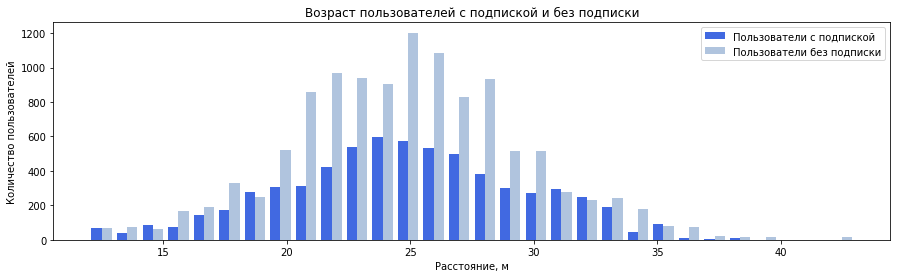

In [123]:
# Рассмотрим возраст пользователей с подпиской и без

plt.figure(figsize=(15,4))

plt.title('Возраст пользователей с подпиской и без подписки')

x1 = list(data_ultra['age'])
x2 = list(data_free['age'])

colors = ['RoyalBlue', 'LightSteelBlue']
names = ['Пользователи с подпиской', 'Пользователи без подписки']

plt.hist([x1, x2], bins=30, color = colors, label = names)
plt.legend()

plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');

По возрасту распределение пользователей с подпиской более равномерное (нормальное распределение), нежели у пользователей без подписки. Во стором случае мы видим пик значений на отметке 25-26 лет, и довольно большой прирост пользователей от 21 до 28 лет.

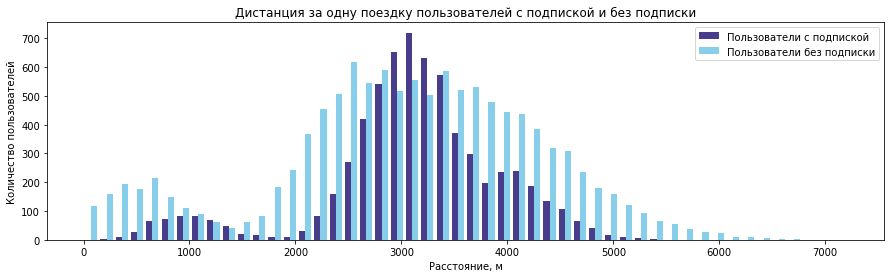

In [124]:
# Рассмотрим расстояние, которое проезжают пользователи с подпиской и без

plt.figure(figsize=(15,4))

plt.title('Дистанция за одну поездку пользователей с подпиской и без подписки')

x1 = list(data_ultra['distance'])
x2 = list(data_free['distance'])

colors = ['DarkSlateBlue', 'SkyBlue']
names = ['Пользователи с подпиской', 'Пользователи без подписки']

plt.hist([x1, x2], bins=50, color = colors, label=names)
plt.legend()

plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей');


Здесь графики похожи, выделяются группы поездок:

* у пользователей с подпиской:
  * короткие - от 0 до 2 км
  * средние - от 2 до 3,8 км (с пиком в 3,2-3,3 км)
  * длинные - от 3,8 до 5 км
  
  
* у пользователей без подписки:
  * короткие - от 0 до 1,5 км
  * средние - от 1,5 до 3,3 км (но тут неявный переход)
  * длинные - от 3,3 до 6 км

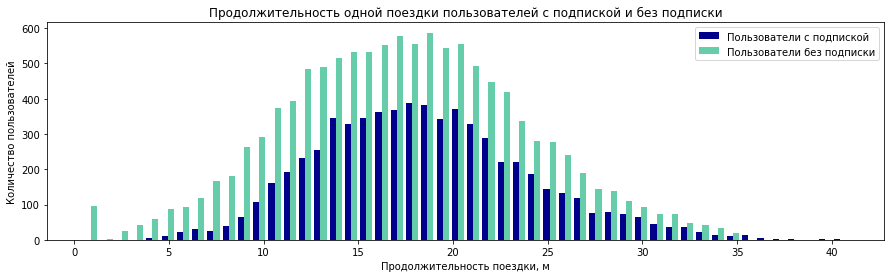

In [125]:
# Рассмотрим расстояние, которое проезжают пользователи с подпиской и без

plt.figure(figsize=(15,4))
plt.title('Продолжительность одной поездки пользователей с подпиской и без подписки')

x1 = list(data_ultra['duration'])
x2 = list(data_free['duration'])

colors = ['DarkBlue', 'MediumAquamarine']
names = ['Пользователи с подпиской', 'Пользователи без подписки']

plt.hist([x1, x2], bins=50, color = colors, label=names)
plt.legend()

plt.xlabel('Продолжительность поездки, м')
plt.ylabel('Количество пользователей');

Продолжительнось поездки выглядит практически одинаково. Небольшие отличия: у пользователей с подпиской длительнсть поездки начинается с примерно 4-х минут и до 40 (чуть больше график смещен вправо), у пользователей без подписки поездки начинаются от 0 и длятся до 35 минут.

И тут мы снова встречаем всплеск на 1й минуте у пользователей без подписки.

In [126]:
# Посмотрим, приносят ли они выручку

data_free.query('duration <= 1')[['start_ride_price', 'minute_price']].sum().to_frame()

,0
start_ride_price,4750
minute_price,760


Да, пожалуй, удалять данные не нужно.

In [127]:
data_free.query('duration <= 1')['age'].value_counts().to_frame().T

,25,24,27,31,21,22,26,30,23,28,29,19,20,32,18,33,34,13,16,17,36
age,12,9,8,8,7,6,6,6,6,5,5,3,3,2,2,2,1,1,1,1,1


А пользователи разного, довольно сознательного возраста в этой группе. Не понятно, почему возникает этот всплеск.

#### Шаг 5. Подсчёт выручки

Создадим файл с агрегированными данными о поездках на основе объединенного файла из предыдущего шага: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [128]:
# Округлим до верхнего ближайшего целого числа продолжительность поездки

data['duration'] = np.ceil(data['duration'])

In [129]:
# Создадим новый файл на основе сводной таблицы
# Добавим также вспомогательные колонки для расчета

data_agg = data.pivot_table(
    index=['month_num', 'user_id'],
    values=['distance', 'duration', 'name', 'subscription_type', 'start_ride_price', 'minute_price', 'subscription_fee'],
    aggfunc=(
        {'distance':'sum', 'duration':'sum', 'name':"count", 'subscription_type':'first', 'start_ride_price':'first', 'minute_price':'first', 'subscription_fee':'first'}
    )
).reset_index(
).rename(
    columns=(
        {'name':'count'}
    )
)

In [130]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month_num          11331 non-null  int64  
 1   user_id            11331 non-null  int64  
 2   distance           11331 non-null  float64
 3   duration           11331 non-null  float64
 4   minute_price       11331 non-null  int64  
 5   count              11331 non-null  int64  
 6   start_ride_price   11331 non-null  int64  
 7   subscription_fee   11331 non-null  int64  
 8   subscription_type  11331 non-null  object 
dtypes: float64(2), int64(6), object(1)
memory usage: 796.8+ KB


UPD:

Пропусков в талбицах нет.

Добавим в наш новый файл с агрегированными данные выручку по каждому пользователю по месячно.

In [131]:
# В сводной таблице добавим колонку с выручкой

data_agg['revenue'] = data_agg['start_ride_price'] * data_agg['count'] + data_agg['minute_price'] * data_agg['duration'] + data_agg['subscription_fee']

In [132]:
# Посмотрим, что получилось

data_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month_num          11331 non-null  int64  
 1   user_id            11331 non-null  int64  
 2   distance           11331 non-null  float64
 3   duration           11331 non-null  float64
 4   minute_price       11331 non-null  int64  
 5   count              11331 non-null  int64  
 6   start_ride_price   11331 non-null  int64  
 7   subscription_fee   11331 non-null  int64  
 8   subscription_type  11331 non-null  object 
 9   revenue            11331 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 885.4+ KB


In [133]:
data_agg.head()

,month_num,user_id,distance,duration,minute_price,count,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,7027.51,42.00,6,2,0,199,ultra,451.00
1,1,3,3061.78,13.00,6,1,0,199,ultra,277.00
2,1,5,3914.65,13.00,6,1,0,199,ultra,277.00
3,1,7,6478.08,28.00,6,2,0,199,ultra,367.00
4,1,12,3577.15,33.00,6,1,0,199,ultra,397.00


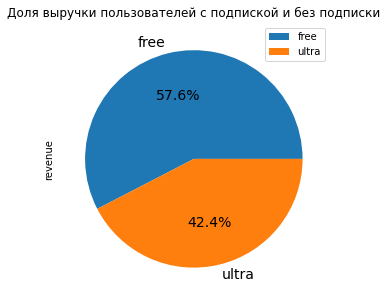

In [134]:
# Посмотрим на распределение выручки от пользователей с подпиской и без

data_agg.groupby('subscription_type')['revenue'].sum().to_frame(
).plot(
    title="Доля выручки пользователей с подпиской и без подписки",
    y='revenue',
    kind = 'pie',
    fontsize = 14,
    autopct='%1.1f%%',
    figsize=(5,5)
);

Суммарно выручка пользователей без подписки выше, чем пользователей с подпиской. Но мы знаем, что и доля их в общем числе пользователей несколько выше.

In [135]:
# Посмотрим выручку в расчете на одного пользователя

(data_agg.groupby('subscription_type')['revenue'].sum() / data_agg.groupby('subscription_type')['revenue'].count()).to_frame()

,revenue
subscription_type,
free,328.64
ultra,362.79


Здесь получается, что пользователь с подпиской приносит на 9,5 % больше выручки, чем пользователь без подписки. Даже с учетом количества пользователей в обеих группах и числа поездок.

#### Шаг 6. Проверка гипотез

Теперь попробуем проверить гипотезы о различии (или нет) ряда определенных параметров для пользователей с подпиской и без.

##### Продолжительность поездки

UPD:

Нулевая гипотеза: Средняя продолжительность сессии для пользователей с подпиской равна средней продолжительности сессии для пользователей без подписки.

UPD:

Альтернативная гипотеза: Средняя продолжительность сессии для пользователей с подпиской больше срденей продолжительности сессии для пользователей без подписки.

In [136]:
# Зададим уровень статистической значимости

alpha = 0.05

In [137]:
#  В новую переменную сохраним данные о распределении вероятностей

results = st.ttest_ind(data_ultra['duration'],  data_free['duration'], alternative = 'greater')

In [138]:
# Выведем p-value

results.pvalue

1.2804098316645618e-34

Вероятность при верной нулевой гипотезе получить наблюдаемое значение или больше, крайне низка. 

In [139]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны')

Отвергаем нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны


**Вывод:**
Нулевая гипотеза отвергнута, есть основания утверждать, что средняя продолжительность каждой сессии пользователей с подпиской больше, чем пользователей без подписки.

##### Расстояние поездки

Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Альтернативная гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.

In [140]:
# Зададим уровень статистической значимости

alpha = 0.05

In [141]:
# Зададим значение оптимального расстояния

optimal_distance = 3130

In [142]:
#  В новую переменную сохраним данные о распределении вероятностей

results = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative = 'greater')

In [143]:
# Выведем p-value

results.pvalue

0.9195368847849785

In [144]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу о том, что Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров')

Не получилось отвергнуть нулевую гипотезу о том, что Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров


UPD

**Вывод:**
Не получилось отвергнуть нулевую гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров. 

Следовательно, износ самокатов, вероятно, не превышает оптимальное значение.

##### Выручка от пользователей с подпиской и пользователей без подписки

UPD

Нулевая гипотеза: Средняя помесячная выручка от пользователей с подпиской по месяцам равна средней выручке от пользователей без подписки.

UPD

Альтернативная гипотеза: Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя выручка от пользователей без подписки.

In [145]:
# Зададим уровень статистической значимости

alpha = 0.05

In [146]:
#  В новую переменную сохраним данные о распределении вероятностей

results = st.ttest_ind(data_agg.query('subscription_type == "ultra"')['revenue'],  data_agg.query('subscription_type == "free"')['revenue'], alternative = 'greater')

In [147]:
# Выведем p-value

results.pvalue

1.8850394384715216e-31

In [148]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны')

Отвергаем нулевую гипотезу о том, что продолжительности сессий для пользователей с подпиской и без равны


**Вывод:**
Нулевая гипотеза отвергнута, есть основания утверждать, что средняя месячная выручка пользователей Ultra выше средней выручки пользователей Free

##### Обновление сервера

Здесь речь идет о проверке состояния генеральной совокупности ДО и ПОСЛЕ изменений. Т.е. Проверяем гипотезу о равенстве средних двух зависимых (парных) выборок:

st.ttest_rel()

UPD

Речь идет о проверке односторонней гипотезы. И, насколько я поняла, нужно проверять правостороннюю гипотезу, задав параметр alternative = 'greater'. Те выполнится проверка, что среднее количество обращений До изменения было Меньше, чем После. 

#### Шаг 7. Распределения

##### Промо-коды

В данном условии речь идет о биномиальном распределении.

В пределах вероятности до 5% находится крайне незначительная часть графика при n=150

mu = n * p

sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

x = 100

result = distr.cdf(x)
print(result)

##### Push-уведомления

In [149]:
# Количество уведомлений, которое планируют разослать

n = 1000000

In [150]:
# Вероятность открытия уведомления

p = 0.4

In [151]:
# Математическое ожидание

mu = n * p

In [152]:
# Стандартное отклонение

sigma = sqrt(n * p * (1 - p))

In [153]:
# Распределение вероятностей

distr = st.norm(mu, sigma)

In [154]:
# Вероятность получить, не более 399,5 тыс открытий (проверяем левый хвост)

result = distr.cdf(399500)

In [155]:
# Значение вероятности в процентах

round(result*100, 2)

15.37

Вероятность, что уведомление откроют не больше 399,5 тыс пользователей 15,37% - относительно небольшая. Скорее всего число открывших уведомление, будет превышать 399,5 тыс.

#### Общий вывод

Полученные исходные данные корректны: нет пропусков, не много явных дубликатов. 

Данные распределены по городам в сравнимых пропорциях. Больше всего данных по Пятигорску, меньше всего по Москве. 

Доля пользователей без подписки (54,1%) несколько больше доли пользователей с подпиской (45,9%).

Основная возрастная группа: от 22 до 28 лет, медианный возраст пользователей - 25 лет. 

В параметре Рассстояние за одну поездку наблюдаются две группы: короткие поездки (до 1,5 км, с пиком в ~ 800м) и длительные (от 1,5 до 6-7км,  с пиком в 2,8-3,4км).
Медианное расстояние составляет 3,133км.
Следует отметить, что это незначительно превышает оптимальное расстояние с точки зрения износа самокатов. (на 0,01%, те разница ничтожна)
Возможно, здесь есть ошибка в единицах измерения (м вместо км).

Длительность поездок распределена довольно равномерно до 35 минут, с пиком в 15-20 мин. 
Медианное значение составляет 17,68 минут.
Однако, здесь есть выброс в пределах 0-1 минут, 95 поездок. Возможно, это сбой или ошибка приложения. 

После слияния таблиц, было выявлено, что количество поездок у пользователей с подпиской почти вдвое меньше, чем у пользователей без подписки. По возрасту эти группы практически не отличаются. А расстояние за одну поездку и длительность одной поездки чуть выше в группе пользователей с подпиской.

Суммарная выручка выше для пользователей без подписки. Но в среднем, пользователь с подпиской приносит на 9,5% выручки больше, чем пользователь без подписки, хотя количество поездок у пользователей с подпиской почти в 2 раза ниже, чем у пользователей без подписки.

В результате проверки гипотез для пользователей с подпиской (по сравнению с пользователями без подписки) есть основания утверждать, что:
* Средняя продолжительность каждой сессии дольше
* Среднее расстояние за одну поездку незначительно превышает 3 130 метров
* Средняя месячная выручка выше

При Обновлении сервера проверить, снизится ли число обращений в тех поддержку, можно будет с помощью метода .st.ttest_rel().(Правая односторонняя проверка гипотезы о равенстве средних двух зависимых (парных) выборок.)

В целом, получается, что пользователи с подпиской более выгодны компании, чем пользователи без подписки. Число поездок у них в 2 раза меньше, расстояние (медианное) незначительно превышает оптимальное для износа саомката, а выручки каждый пользователь приносит на 9,5% больше, чем пользователь без подписки.